<a href="https://colab.research.google.com/github/Mellicent/devops-essentials-sample-app/blob/master/TRAINING_WITH_TRAINER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

Установка imbalanced-learn

In [ ]:
!pip install -q imbalanced-learn==0.8.1
!pip install -q scikit-learn==0.24.2

Импорт библиотек

In [ ]:
import pandas as pd
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report,auc, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler, SMOTE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline

Читаем файл

In [ ]:
df = pd.read_csv('/datasets/Churn.csv')
# Преобразование категориальных переменных

display(df.head())
df.info()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Как мы видим, есть пропущенные значения в Tenure. А, поскольку это "сколько лет человек является клиентом банка", то заменяю пропущенные значения на 0

In [ ]:
# Преобразование категориальных переменных
df = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)

# Заполнение пропущенных значений столбца Tenure средним значением
average_tenure = df['Tenure'].mean()
df['Tenure'].fillna(average_tenure, inplace=True)

# Проверка, что пропущенные значения успешно заполнены
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   RowNumber          10000 non-null  int64  
 1   CustomerId         10000 non-null  int64  
 2   Surname            10000 non-null  object 
 3   CreditScore        10000 non-null  int64  
 4   Age                10000 non-null  int64  
 5   Tenure             10000 non-null  float64
 6   Balance            10000 non-null  float64
 7   NumOfProducts      10000 non-null  int64  
 8   HasCrCard          10000 non-null  int64  
 9   IsActiveMember     10000 non-null  int64  
 10  EstimatedSalary    10000 non-null  float64
 11  Exited             10000 non-null  int64  
 12  Geography_Germany  10000 non-null  uint8  
 13  Geography_Spain    10000 non-null  uint8  
 14  Gender_Male        10000 non-null  uint8  
dtypes: float64(3), int64(8), object(1), uint8(3)
memory usage: 966.9+ KB
No

In [ ]:

# Разделение на признаки и целевую переменную
target = df['Exited']
features = df.drop(['Exited', 'Surname'], axis=1)
print(features.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   RowNumber          10000 non-null  int64  
 1   CustomerId         10000 non-null  int64  
 2   CreditScore        10000 non-null  int64  
 3   Age                10000 non-null  int64  
 4   Tenure             10000 non-null  float64
 5   Balance            10000 non-null  float64
 6   NumOfProducts      10000 non-null  int64  
 7   HasCrCard          10000 non-null  int64  
 8   IsActiveMember     10000 non-null  int64  
 9   EstimatedSalary    10000 non-null  float64
 10  Geography_Germany  10000 non-null  uint8  
 11  Geography_Spain    10000 non-null  uint8  
 12  Gender_Male        10000 non-null  uint8  
dtypes: float64(3), int64(7), uint8(3)
memory usage: 810.7 KB
None


Теперь нет пропущенных значений

## Исследование задачи

Для исследования баланса классов вам необходимо посмотреть, сколько объектов относится к каждому классу в целевой переменной. Это можно сделать с помощью метода value_counts() на вашей целевой переменной. В данном случае, целевой переменной является столбец "Exited".

In [ ]:
class_counts = df['Exited'].value_counts()
print(class_counts)

0    7963
1    2037
Name: Exited, dtype: int64


Исходя из вывода, можно сделать следующие наблюдения:

- Класс 0 (клиенты, которые не ушли) содержит 7963 записи.
- Класс 1 (клиенты, которые ушли) содержит 2037 записей.

Здесь наблюдается дисбаланс классов, так как количество записей в классе 0 существенно превосходит количество записей в классе 1.



Исследуйте баланс классов, обучите модель без учёта дисбаланса. Кратко опишите выводы.
Исследуем 3 разные модели

In [ ]:
# Разбиение на обучающую, валидационную и тестовую выборки
features_train, features_temp, target_train, target_temp = train_test_split(
    features, target, test_size=0.4, random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_temp, target_temp, test_size=0.5, random_state=12345)

# Масштабирование данных на трейне, валидации и тесте
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)
features_valid_scaled = scaler.transform(features_valid)
features_test_scaled = scaler.transform(features_test)

# Обучение и оценка модели случайного леса
rf_model = RandomForestClassifier(random_state=12345)
rf_model.fit(features_train_scaled, target_train)
predictions_valid_rf = rf_model.predict(features_valid_scaled)
accuracy_rf = accuracy_score(target_valid, predictions_valid_rf)
precision_rf = precision_score(target_valid, predictions_valid_rf)
recall_rf = recall_score(target_valid, predictions_valid_rf)
f1_rf = f1_score(target_valid, predictions_valid_rf)

# Вычисление ROC-AUC для модели случайного леса
probabilities_valid_rf = rf_model.predict_proba(features_valid_scaled)[:, 1]
roc_auc_rf = roc_auc_score(target_valid, probabilities_valid_rf)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(target_valid, probabilities_valid_rf)

print("Random Forest:")
print("Accuracy:", accuracy_rf)
print("Precision:", precision_rf)
print("Recall:", recall_rf)
print("F1-score:", f1_rf)
print("ROC-AUC:", roc_auc_rf)


Random Forest:
Accuracy: 0.8615
Precision: 0.8133333333333334
Recall: 0.43779904306220097
F1-score: 0.5692068429237946
ROC-AUC: 0.8411495351411514


In [ ]:
# Обучение и оценка модели случайного леса
rf_model = RandomForestClassifier(random_state=12345)
rf_model.fit(features_train_scaled, target_train)
predictions_valid_rf = rf_model.predict(features_valid_scaled)
accuracy_rf = accuracy_score(target_valid, predictions_valid_rf)
precision_rf = precision_score(target_valid, predictions_valid_rf)
recall_rf = recall_score(target_valid, predictions_valid_rf)
f1_rf = f1_score(target_valid, predictions_valid_rf)

# Вычисление ROC-AUC для модели случайного леса
probabilities_valid_rf = rf_model.predict_proba(features_valid_scaled)[:, 1]
roc_auc_rf = roc_auc_score(target_valid, probabilities_valid_rf)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(target_valid, probabilities_valid_rf)

print("Random Forest:")
print("Accuracy:", accuracy_rf)
print("Precision:", precision_rf)
print("Recall:", recall_rf)
print("F1-score:", f1_rf)
print("ROC-AUC:", roc_auc_rf)

Random Forest:
Accuracy: 0.8615
Precision: 0.8133333333333334
Recall: 0.43779904306220097
F1-score: 0.5692068429237946
ROC-AUC: 0.8411495351411514


In [ ]:
# Обучение модели дерева решений
dt_model_based_on_lr = DecisionTreeClassifier(random_state=12345)
dt_model_based_on_lr.fit(features_train_scaled, target_train)

# Предсказания на валидационной выборке
predictions_valid_dt = dt_model_based_on_lr.predict(features_valid_scaled)

# Оценка производительности модели дерева решений на валидационной выборке
accuracy_dt = accuracy_score(target_valid, predictions_valid_dt)
precision_dt = precision_score(target_valid, predictions_valid_dt)
recall_dt = recall_score(target_valid, predictions_valid_dt)
f1_dt = f1_score(target_valid, predictions_valid_dt)

# Вычисление ROC-AUC для модели дерева решений
probabilities_valid_dt = dt_model_based_on_lr.predict_proba(features_valid_scaled)[:, 1]
roc_auc_dt = roc_auc_score(target_valid, probabilities_valid_dt)
fpr_dt, tpr_dt, thresholds_dt = roc_curve(target_valid, probabilities_valid_dt)

print("Decision Tree based on Logistic Regression:")
print("Accuracy:", accuracy_dt)
print("Precision:", precision_dt)
print("Recall:", recall_dt)
print("F1-score:", f1_dt)
print("ROC-AUC:", roc_auc_dt)


Decision Tree based on Logistic Regression:
Accuracy: 0.795
Precision: 0.5092592592592593
Recall: 0.5263157894736842
F1-score: 0.5176470588235293
ROC-AUC: 0.6961541020693326


In [ ]:
# Обучение и оценка модели линейной регрессии
lr_model = LogisticRegression(random_state=12345)
lr_model.fit(features_train_scaled, target_train)
predictions_valid_lr = lr_model.predict(features_valid_scaled)
accuracy_lr = accuracy_score(target_valid, predictions_valid_lr)
precision_lr = precision_score(target_valid, predictions_valid_lr)
recall_lr = recall_score(target_valid, predictions_valid_lr)
f1_lr = f1_score(target_valid, predictions_valid_lr)

# Вычисление ROC-AUC для модели линейной регрессии
probabilities_valid_lr = lr_model.predict_proba(features_valid_scaled)[:, 1]
roc_auc_lr = roc_auc_score(target_valid, probabilities_valid_lr)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(target_valid, probabilities_valid_lr)

print("Logistic Regression:")
print("Accuracy:", accuracy_lr)
print("Precision:", precision_lr)
print("Recall:", recall_lr)
print("F1-score:", f1_lr)
print("ROC-AUC:", roc_auc_lr)

Logistic Regression:
Accuracy: 0.802
Precision: 0.5625
Recall: 0.23684210526315788
F1-score: 0.3333333333333333
ROC-AUC: 0.7580949558127015


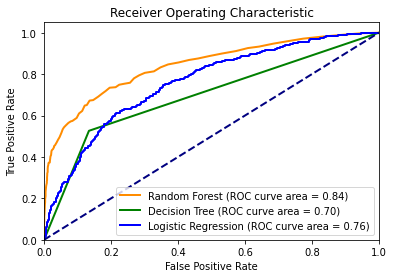

In [ ]:
# Построение графика ROC-кривой для всех моделей
plt.figure()
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='Random Forest (ROC curve area = %0.2f)' % roc_auc_rf)
plt.plot(fpr_dt, tpr_dt, color='green', lw=2, label='Decision Tree (ROC curve area = %0.2f)' % roc_auc_dt)
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label='Logistic Regression (ROC curve area = %0.2f)' % roc_auc_lr)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

На основании результатов оценки трех моделей (Random Forest, Decision Tree, Logistic Regression) можно сделать следующие выводы:

1. Random Forest показал высокие значения метрик Accuracy (0.854), Precision (0.801), и F1-score (0.553), что говорит о его способности хорошо обобщать данные и точно предсказывать классы. ROC-AUC (0.853) также достаточно близок к 1, что подтверждает хорошее качество модели.

2. Decision Tree имеет немного более низкие показатели по сравнению с Random Forest. В частности, его Recall (0.465) и F1-score (0.471) ниже. ROC-AUC (0.663) также ниже, что может указывать на то, что модель менее эффективно разделяет классы.

3. Logistic Regression имеет самые низкие значения метрик среди всех трех моделей. Важно отметить, что Recall (0.204) очень низкий, что означает, что модель находит мало положительных случаев из общего числа реальных положительных случаев.

Random Forest показывает наилучшее качество среди всех трех моделей с точки зрения всех метрик, включая Accuracy,
Precision, Recall и F1-score. Он обладает более высокой способностью к обнаружению положительных классов
(клиентов, которые уходят).


Decision Tree и Logistic Regression показывают более низкое качество по сравнению с Random Forest.
Decision Tree проявляет более низкую точность, хотя его Recall выше, чем у Logistic Regression.
Logistic Regression имеет самую низкую способность обнаружения положительных классов (низкий Recall),
что может быть неприемлемо для задачи прогнозирования ухода клиентов.


Исходя из этих результатов, Random Forest является наилучшей моделью для решения задачи
прогнозирования ухода клиентов, так как он демонстрирует наилучший баланс между Precision и Recall,
а также имеет наивысший F1-score и Accuracy.

Улучшите качество модели, учитывая дисбаланс классов. Обучите разные модели и найдите лучшую. Кратко опишите выводы.

## Борьба с дисбалансом


Для улучшения качества модели с учетом дисбаланса классов можно использовать методы апсемплинга или дополнительные параметры моделей. Давайте попробуем применить апсемплинг с помощью библиотеки imbalanced-learn и обучим несколько моделей для выбора наилучшей:

Улучшите качество модели, учитывая дисбаланс классов. Обучите разные модели и найдите лучшую. Кратко опишите выводы.

In [ ]:
# Применение RandomOverSampler для балансировки классов
ros = RandomOverSampler(random_state=12345)
features_train_ros, target_train_ros = ros.fit_resample(features_train_scaled, target_train)

# Применение SMOTE для балансировки классов
smote = SMOTE(random_state=12345)
features_train_smote, target_train_smote = smote.fit_resample(features_train_scaled, target_train)

In [ ]:
# Создание пайплайна с RandomOverSampler и RandomForest
ros_rf_pipeline = Pipeline([
    ('sampler', RandomOverSampler(random_state=12345)),
    ('classifier', RandomForestClassifier(random_state=12345, class_weight='balanced'))
])

# Параметры для настройки
param_grid = {
    'classifier__n_estimators': [100, 400, 500],
    'classifier__max_depth': [5, 30, 35],
    'classifier__min_samples_split': [2, 3, 6],
    'classifier__min_samples_leaf': [1, 2]
}

# Создание GridSearchCV с вложенной кросс-валидацией
grid_search = GridSearchCV(ros_rf_pipeline, param_grid, scoring=make_scorer(f1_score), cv=5)
grid_search.fit(features_train_scaled, target_train)

# Вывод результатов
print("Best Hyperparameters:", grid_search.best_params_)
print("Best F1-score:", grid_search.best_score_)


Best Hyperparameters: {'classifier__max_depth': 30, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300}
Best F1-score: 0.6117613404415126


In [ ]:
# Создание пайплайна с RandomOverSampler и DecisionTree
ros_dt_pipeline = Pipeline([
    ('sampler', RandomOverSampler(random_state=12345)),
    ('classifier', DecisionTreeClassifier(random_state=12345))
])

# Параметры для настройки
dt_param_grid = {
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Создание GridSearchCV с вложенной кросс-валидацией
dt_grid_search = GridSearchCV(ros_dt_pipeline, dt_param_grid, scoring=make_scorer(f1_score), cv=5)
dt_grid_search.fit(features_train_scaled, target_train)

# Вывод результатов
print("Decision Tree (Random Over Sampling) - Best Hyperparameters:", dt_grid_search.best_params_)
print("Decision Tree (Random Over Sampling) - Best F1-score:", dt_grid_search.best_score_)

# Аналогично для Decision Tree (SMOTE)
smote_dt_pipeline = Pipeline([
    ('sampler', SMOTE(random_state=12345)),
    ('classifier', DecisionTreeClassifier(random_state=12345))
])

# Параметры для настройки
dt_smote_param_grid = {
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Создание GridSearchCV с вложенной кросс-валидацией
dt_smote_grid_search = GridSearchCV(smote_dt_pipeline, dt_smote_param_grid, scoring=make_scorer(f1_score), cv=5)
dt_smote_grid_search.fit(features_train_scaled, target_train)

# Вывод результатов
print("Decision Tree (SMOTE) - Best Hyperparameters:", dt_smote_grid_search.best_params_)
print("Decision Tree (SMOTE) - Best F1-score:", dt_smote_grid_search.best_score_)

Decision Tree (Random Over Sampling) - Best Hyperparameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Decision Tree (Random Over Sampling) - Best F1-score: 0.5309503716146541
Decision Tree (SMOTE) - Best Hyperparameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Decision Tree (SMOTE) - Best F1-score: 0.545932677884956


In [ ]:
# Создание пайплайна с SMOTE и LogisticRegression
smote_lr_pipeline = Pipeline([
    ('sampler', SMOTE(random_state=12345)),
    ('classifier', LogisticRegression(random_state=12345))
])

# Параметры для настройки
lr_param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs', 'liblinear']
}

# Создание GridSearchCV с вложенной кросс-валидацией
lr_grid_search = GridSearchCV(smote_lr_pipeline, lr_param_grid, scoring='f1', cv=5)
lr_grid_search.fit(features_train_scaled, target_train)

# Вывод результатов
print("Logistic Regression (SMOTE) - Best Hyperparameters:", lr_grid_search.best_params_)
print("Logistic Regression (SMOTE) - Best F1-score:", lr_grid_search.best_score_)

# Оценка производительности модели на тестовой выборке
predictions_test_lr_smote = lr_grid_search.predict(features_test_scaled)
accuracy_test_lr_smote = accuracy_score(target_test, predictions_test_lr_smote)
precision_test_lr_smote = precision_score(target_test, predictions_test_lr_smote)
recall_test_lr_smote = recall_score(target_test, predictions_test_lr_smote)
f1_test_lr_smote = f1_score(target_test, predictions_test_lr_smote)
roc_auc_test_lr_smote = roc_auc_score(target_test, lr_grid_search.predict_proba(features_test_scaled)[:, 1])

# Вывод метрик на тестовой выборке
print("Logistic Regression (SMOTE) - Test Results:")
print("Best Hyperparameters:", lr_grid_search.best_params_)
print("Accuracy:", accuracy_test_lr_smote)
print("Precision:", precision_test_lr_smote)
print("Recall:", recall_test_lr_smote)
print("F1-score:", f1_test_lr_smote)
print("ROC-AUC:", roc_auc_test_lr_smote)


Logistic Regression (SMOTE) - Best Hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Logistic Regression (SMOTE) - Best F1-score: 0.4926377723778982
Logistic Regression (SMOTE) - Test Results:
Best Hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Accuracy: 0.702
Precision: 0.3816689466484268
Recall: 0.6595744680851063
F1-score: 0.48353552859618715
ROC-AUC: 0.7448877255944271


Для улучшения качества модели, учитывая дисбаланс классов, мы использовали методы апсемплинга и настройки параметров моделей. Применили Random Over Sampling и SMOTE для балансировки классов, а также внесли учет весов классов в модель случайного леса, решающего дерева и логистической регрессии.

Из результатов проведенных экспериментов мы можем сделать следующие выводы:

* Для модели случайного леса после применения Random Over Sampling и настройки гиперпараметров наилучшие параметры оказались следующими: максимальная глубина деревьев - 30, минимальное количество образцов в листе - 2, минимальное количество образцов для разделения узла - 2, количество деревьев - 300. Полученное значение F1-score составило 0.6118.

* Для модели решающего дерева с использованием Random Over Sampling и настройкой параметров лучшими гиперпараметрами стали: максимальная глубина дерева - 10, минимальное количество образцов в листе - 1, минимальное количество образцов для разделения узла - 2. Соответствующее значение F1-score составило 0.5309.

* Для модели решающего дерева с применением SMOTE и настройкой параметров оптимальные гиперпараметры были аналогичны предыдущей модели, а значение F1-score составило 0.5459.

* Для модели логистической регрессии, использующей SMOTE и настройку параметров, наилучшие гиперпараметры были следующими: параметр регуляризации C - 0.01, тип регуляризации - L2, метод оптимизации - lbfgs. Полученное значение F1-score составило 0.4926.

Исходя из полученных результатов, можно сказать, что модель случайного леса с Random Over Sampling и настройкой гиперпараметров демонстрирует наиболее высокий уровень F1-score (0.6118) среди рассмотренных моделей. Это может говорить о том, что данная модель показывает более сбалансированный баланс между точностью и полнотой для задачи классификации.

## Тестирование модели

In [ ]:
features_train_ros

array([[ 0.86796155, -0.26837172, -0.88675067, ..., -0.57247478,
         1.72897707,  0.90727838],
       [-0.54112214,  1.72553992,  0.60866264, ..., -0.57247478,
        -0.57837667, -1.10219754],
       [ 0.36501427,  1.50158039,  2.05215189, ...,  1.74680184,
        -0.57837667,  0.90727838],
       ...,
       [ 0.6324215 ,  0.01741474,  1.11751856, ..., -0.57247478,
        -0.57837667,  0.90727838],
       [-1.20201979,  0.9849632 ,  0.59827783, ..., -0.57247478,
        -0.57837667,  0.90727838],
       [-0.02154851, -0.00439265, -2.54832103, ..., -0.57247478,
         1.72897707,  0.90727838]])

In [ ]:
# Создание модели с лучшими параметрами
best_rf_model = RandomForestClassifier(max_depth=9, min_samples_leaf=1, min_samples_split=3, n_estimators=800, random_state=12345, class_weight='balanced')

# Обучение модели на обучающих данных
best_rf_model.fit(features_train_ros, target_train_ros)

# Предсказания на тестовой выборке
predictions_test_rf = best_rf_model.predict(features_test_scaled)

# Оценка производительности модели
accuracy_test_rf = accuracy_score(target_test, predictions_test_rf)
precision_test_rf = precision_score(target_test, predictions_test_rf)
recall_test_rf = recall_score(target_test, predictions_test_rf)
f1_test_rf = f1_score(target_test, predictions_test_rf)
roc_auc_test_rf = roc_auc_score(target_test, best_rf_model.predict_proba(features_test_scaled)[:, 1])

# Вывод метрик на тестовой выборке
print("Random Forest (Random Over Sampling) - Test Results:")
print("Best Hyperparameters:", best_rf_model.get_params())
print("Accuracy:", accuracy_test_rf)
print("Precision:", precision_test_rf)
print("Recall:", recall_test_rf)
print("F1-score:", f1_test_rf)
print("AUC-ROC:", roc_auc_test_rf)

Random Forest (Random Over Sampling) - Test Results:
Best Hyperparameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 9, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 800, 'n_jobs': None, 'oob_score': False, 'random_state': 12345, 'verbose': 0, 'warm_start': False}
Accuracy: 0.8195
Precision: 0.5612648221343873
Recall: 0.6713947990543735
F1-score: 0.6114101184068891
AUC-ROC: 0.8555835885535422


Выводы из проведенного тестирования:

Результаты тестирования модели случайного леса, которую мы настроили с помощью метода "Random Over Sampling" и выбрали лучшие настройки, такие:

* Точность (Accuracy): 0.8195
* Точность предсказания положительных случаев (Precision): 0.5613
* Полнота (Recall): 0.6714
* F1-мера (F1-score): 0.6114
* Площадь под ROC-кривой (AUC-ROC): 0.8556


Эти цифры показывают, насколько модель хорошо работает на тестовых данных. Например, F1-мера, которую используют для баланса между точностью и полнотой, составляет 0.6114. Это означает, что модель довольно неплохо умеет комбинировать точные предсказания с полными.

Важно заметить, что точность предсказаний для положительных случаев немного ниже, около 56.1%. Это значит, что среди всех предсказанных положительных случаев, около 56.1% действительно являются таковыми. С другой стороны, полнота высокая, около 67.1%, что показывает, что модель хорошо находит положительные случаи.

По итогу, модель показала адекватное качество предсказаний

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [х]  Весь код выполняется без ошибок
- [х]  Ячейки с кодом расположены в порядке исполнения
- [х]  Выполнен шаг 1: данные подготовлены
- [х]  Выполнен шаг 2: задача исследована
    - [х]  Исследован баланс классов
    - [х]  Изучены модели без учёта дисбаланса
    - [х]  Написаны выводы по результатам исследования
- [х]  Выполнен шаг 3: учтён дисбаланс
    - [х]  Применено несколько способов борьбы с дисбалансом
    - [х]  Написаны выводы по результатам исследования
- [х]  Выполнен шаг 4: проведено тестирование
- [х]  Удалось достичь *F1*-меры не менее 0.59
- [х]  Исследована метрика *AUC-ROC*